# 3.2 线性回归的从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.3.0


## 3.2.1 生成数据集

In [21]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
#                        dtype=torch.float32)
labels += torch.tensor(np.random.normal(0, 0.01), dtype=torch.float32)

In [25]:
print(features.shape)
print(labels.size())

torch.Size([1000, 2])
torch.Size([1000])


In [27]:
print(features[0], labels[0])
print(features[-1], labels[-1])

tensor([0.4639, 0.6211]) tensor(3.0191)
tensor([ 0.1784, -0.2445]) tensor(5.3912)


In [28]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        The data positions.
    
    s : scalar or array_like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : color, sequence, or sequence of color, optional
        The marker color. Possible values:
    
        - A single color format string.
        - A sequence of color specifications of length n.
        - A sequence of n numbers to be mapped to colors using *cmap* and
          *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
    
        Note that *c* should not be a single numeric RGB or RGBA sequen

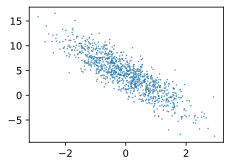

In [47]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
# plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.scatter(features[:, 1].numpy(), labels.numpy(), 0.2)

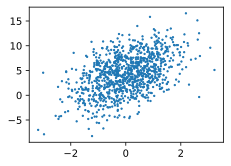

In [48]:
set_figsize()
# plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.scatter(features[:, 0].numpy(), labels.numpy(), 2)

## 3.2.2 读取数据

In [91]:
help(random.shuffle)

Help on method shuffle in module random:

shuffle(x, random=None) method of random.Random instance
    Shuffle list x in place, and return None.
    
    Optional argument random is a 0-argument function returning a
    random float in [0.0, 1.0); if it is the default None, the
    standard random.random will be used.



In [92]:
x = list(range(10))
print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [93]:
random.shuffle(x)
print(x)

[4, 0, 7, 6, 2, 9, 5, 3, 8, 1]


In [98]:
num_examples = len(features)
batch_size = 10
print(list(range(0, num_examples, batch_size)))
print(len(list(range(0, num_examples, batch_size))))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]
100


In [108]:
# See https://pytorch.org/docs/stable/tensors.html for LongTensor

In [104]:
help(torch.index_select)

Help on built-in function index_select:

index_select(...)
    index_select(input, dim, index, out=None) -> Tensor
    
    Returns a new tensor which indexes the :attr:`input` tensor along dimension
    :attr:`dim` using the entries in :attr:`index` which is a `LongTensor`.
    
    The returned tensor has the same number of dimensions as the original tensor
    (:attr:`input`).  The :attr:`dim`\ th dimension has the same size as the length
    of :attr:`index`; other dimensions have the same size as in the original tensor.
    
    .. note:: The returned tensor does **not** use the same storage as the original
              tensor.  If :attr:`out` has a different shape than expected, we
              silently change it to the correct shape, reallocating the underlying
              storage if necessary.
    
    Args:
        input (Tensor): the input tensor.
        dim (int): the dimension in which we index
        index (LongTensor): the 1-D tensor containing the indices to index


In [161]:
indices = list(range(num_examples))
random.shuffle(indices) 
print(indices)

[434, 139, 192, 444, 189, 56, 903, 511, 581, 870, 164, 481, 553, 292, 421, 93, 995, 33, 512, 282, 702, 242, 20, 502, 321, 302, 689, 836, 54, 214, 832, 310, 671, 470, 439, 401, 89, 263, 911, 57, 315, 969, 94, 361, 694, 734, 80, 304, 760, 248, 357, 309, 661, 670, 326, 854, 736, 719, 268, 551, 69, 127, 773, 607, 466, 674, 742, 353, 792, 183, 869, 64, 7, 986, 709, 570, 382, 474, 277, 669, 330, 106, 701, 211, 149, 467, 77, 410, 556, 841, 633, 221, 756, 614, 317, 47, 416, 516, 704, 461, 178, 641, 720, 820, 160, 86, 785, 197, 327, 634, 558, 796, 124, 17, 673, 863, 103, 230, 786, 997, 141, 232, 145, 203, 105, 62, 31, 442, 900, 204, 483, 568, 851, 244, 642, 650, 295, 699, 741, 974, 676, 293, 182, 913, 894, 337, 123, 606, 691, 797, 596, 49, 543, 250, 380, 793, 24, 241, 860, 61, 420, 925, 332, 239, 517, 355, 724, 707, 947, 412, 32, 599, 520, 452, 892, 515, 984, 821, 532, 965, 335, 446, 41, 1, 2, 972, 75, 193, 87, 522, 686, 21, 508, 554, 231, 482, 711, 547, 394, 438, 426, 81, 565, 433, 890, 579, 6

In [162]:
i = 0
j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
print(j)

tensor([434, 139, 192, 444, 189,  56, 903, 511, 581, 870])


In [163]:
i = 10
j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
print(j)

tensor([164, 481, 553, 292, 421,  93, 995,  33, 512, 282])


See https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do to understand `yield` statement.

In [164]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [165]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5393, -0.6944],
        [-0.7202,  1.1918],
        [ 0.2172, -0.1440],
        [-1.1542, -1.1387],
        [-0.8738, -0.6263],
        [ 0.8264, -0.5499],
        [ 1.6733,  0.5341],
        [ 0.8989, -0.2405],
        [-0.5426, -2.2951],
        [ 0.6719, -0.4341]]) 
 tensor([ 5.4854, -1.2896,  5.1272,  5.7662,  4.5849,  7.7254,  5.7338,  6.8186,
        10.9211,  7.0228])


## 3.2.3 初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [9]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [10]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [11]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.034291
epoch 2, loss 0.000112
epoch 3, loss 0.000048


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9998],
        [-3.4001]], requires_grad=True)
4.2 
 tensor([4.1993], requires_grad=True)
